In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


# Представим, что мы работаем дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

Немного о данных:
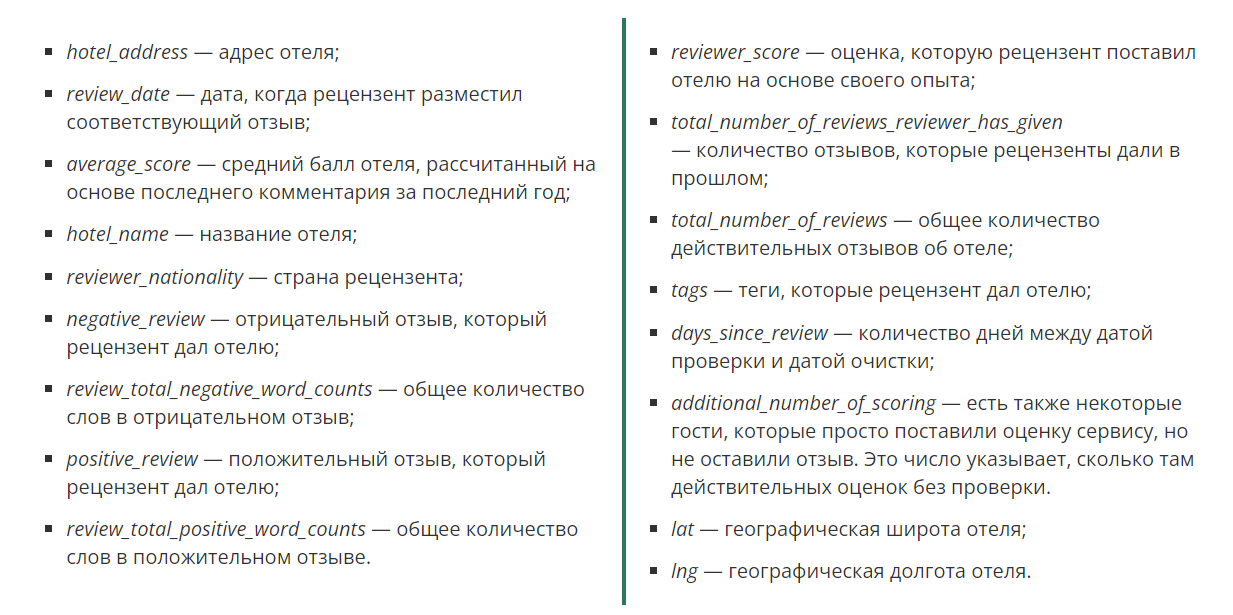

In [57]:
RANDOM_SEED = 42

In [ ]:
hotels_train = pd.read_csv('/kaggle/input/sf-booking/hotels_train.csv')

hotels_train.head(4)

## Загружаем данные

In [7]:
hotels_test = pd.read_csv('/kaggle/input/sf-booking/hotels_test.csv')

hotels_test.head(4)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298


In [8]:
submission = pd.read_csv('/kaggle/input/sf-booking/submission.csv')

submission.head()

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596


Объединим тренировочный и тестовый наборы данных для того, чтобы было удобнее их обработать

In [9]:
hotels_train['sample'] = 1 # пометим тренировочную выборку
hotels_test['sample'] = 0 # пометим тестовую выборку
hotels_test['reviewer_score'] = 0 # добавим тестовому набору данных колонку с рейтингом

hotels = pd.concat([hotels_train, hotels_test], ignore_index=True)

hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,sample
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,1
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,1
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643,1


In [10]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [11]:
hotels.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng,sample
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,512470.000000,512470.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,6.297672,49.442439,2.823803,0.749999
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,3.902295,3.466325,4.579425,0.433014
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,0.000000,41.328376,-0.369758,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,0.625000,48.214662,-0.143372,0.250000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,7.900000,51.499981,0.010607,1.000000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,9.600000,51.516288,4.834443,1.000000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,10.000000,52.400181,16.429233,1.000000


# Заполнение пропущенных значений

Посмотрим на наличие пропущенных значений в наборе данных

In [12]:
hotels.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
reviewer_score                                    38
tags                                           55242
days_since_review                                731
lat                                             1473
lng                                             1473
sample                                             2
dtype: int64

In [13]:
hotels.isnull().sum()

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
reviewer_score                                   0
tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
sample                                           0
dtype: int64

Можно увидеть, что в некоторых отзывах у отелей нет координат. Посмотрим, у каких именно.

In [14]:
mask1 = hotels['lat'].isnull()
mask2 = hotels['lng'].isnull()

hotels_without_coordinates = hotels[mask1 | mask2]['hotel_name'].value_counts().index.tolist()

display(hotels_without_coordinates)

['Fleming s Selection Hotel Wien City',
 'Hotel City Central',
 'Hotel Atlanta',
 'Maison Albar Hotel Paris Op ra Diamond',
 'Hotel Daniel Vienna',
 'Hotel Pension Baron am Schottentor',
 'Austria Trend Hotel Schloss Wilhelminenberg Wien',
 'Derag Livinghotel Kaiser Franz Joseph Vienna',
 'NH Collection Barcelona Podium',
 'City Hotel Deutschmeister',
 'Hotel Park Villa',
 'Cordial Theaterhotel Wien',
 'Holiday Inn Paris Montmartre',
 'Roomz Vienna',
 'Mercure Paris Gare Montparnasse',
 'Renaissance Barcelona Hotel',
 'Hotel Advance']

Так как количество отелей, у которых нет координат, сравнительно небольшое, то самостоятельно поищем их координаты в интернете и заполним пропуски.

In [15]:
hotels.loc[hotels['hotel_name'] == 'Fleming s Selection Hotel Wien City', ['lat', 'lng']] = ['48.206481', '16.363451']
hotels.loc[hotels['hotel_name'] == 'Hotel City Central', ['lat', 'lng']] = ['48.213558', '16.379923']
hotels.loc[hotels['hotel_name'] == 'Hotel Atlanta', ['lat', 'lng']] = ['48.220310', '16.355881']
hotels.loc[hotels['hotel_name'] == 'Maison Albar Hotel Paris Op ra Diamond', ['lat', 'lng']] = ['48.875223', '2.323385']
hotels.loc[hotels['hotel_name'] == 'Hotel Daniel Vienna', ['lat', 'lng']] = ['48.188835', '16.383810']
hotels.loc[hotels['hotel_name'] == 'Hotel Pension Baron am Schottentor', ['lat', 'lng']] = ['48.216705', '16.359819']
hotels.loc[hotels['hotel_name'] == 'Austria Trend Hotel Schloss Wilhelminenberg Wien', ['lat', 'lng']] = ['48.219555', '16.285566']
hotels.loc[hotels['hotel_name'] == 'Derag Livinghotel Kaiser Franz Joseph Vienna', ['lat', 'lng']] = ['48.245914', '16.341188']
hotels.loc[hotels['hotel_name'] == 'NH Collection Barcelona Podium', ['lat', 'lng']] = ['41.391430', '2.177890']
hotels.loc[hotels['hotel_name'] == 'City Hotel Deutschmeister', ['lat', 'lng']] = ['48.220856', '16.366642']
hotels.loc[hotels['hotel_name'] == 'Hotel Park Villa', ['lat', 'lng']] = ['48.233379', '16.345510']
hotels.loc[hotels['hotel_name'] == 'Cordial Theaterhotel Wien', ['lat', 'lng']] = ['48.209530', '16.351515']
hotels.loc[hotels['hotel_name'] == 'Holiday Inn Paris Montmartre', ['lat', 'lng']] = ['48.888860', '2.333190']
hotels.loc[hotels['hotel_name'] == 'Roomz Vienna', ['lat', 'lng']] = ['48.222458', '16.393538']
hotels.loc[hotels['hotel_name'] == 'Mercure Paris Gare Montparnasse', ['lat', 'lng']] = ['48.839701', '2.323519']
hotels.loc[hotels['hotel_name'] == 'Renaissance Barcelona Hotel', ['lat', 'lng']] = ['41.392429', '2.167500']
hotels.loc[hotels['hotel_name'] == 'Hotel Advance', ['lat', 'lng']] = ['41.379389', '2.157475']

In [69]:
hotels['lat'] = hotels['lat'].astype('float64')
hotels['lng'] = hotels['lng'].astype('float64')

Удостоверимся, что пропусков больше нет

In [16]:
hotels.isnull().sum()

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
reviewer_score                                0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
sample                                        0
dtype: int64

# Исследование целевого признака

Text(0.5, 1.0, 'Распределение оценок')

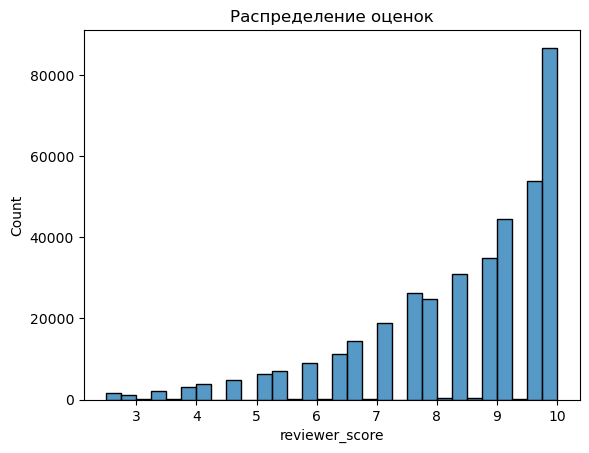

In [18]:
hotels_reviewer_score_hist = sns.histplot(hotels_train['reviewer_score'], bins=30)
hotels_reviewer_score_hist.set_title('Распределение оценок')

<AxesSubplot:>

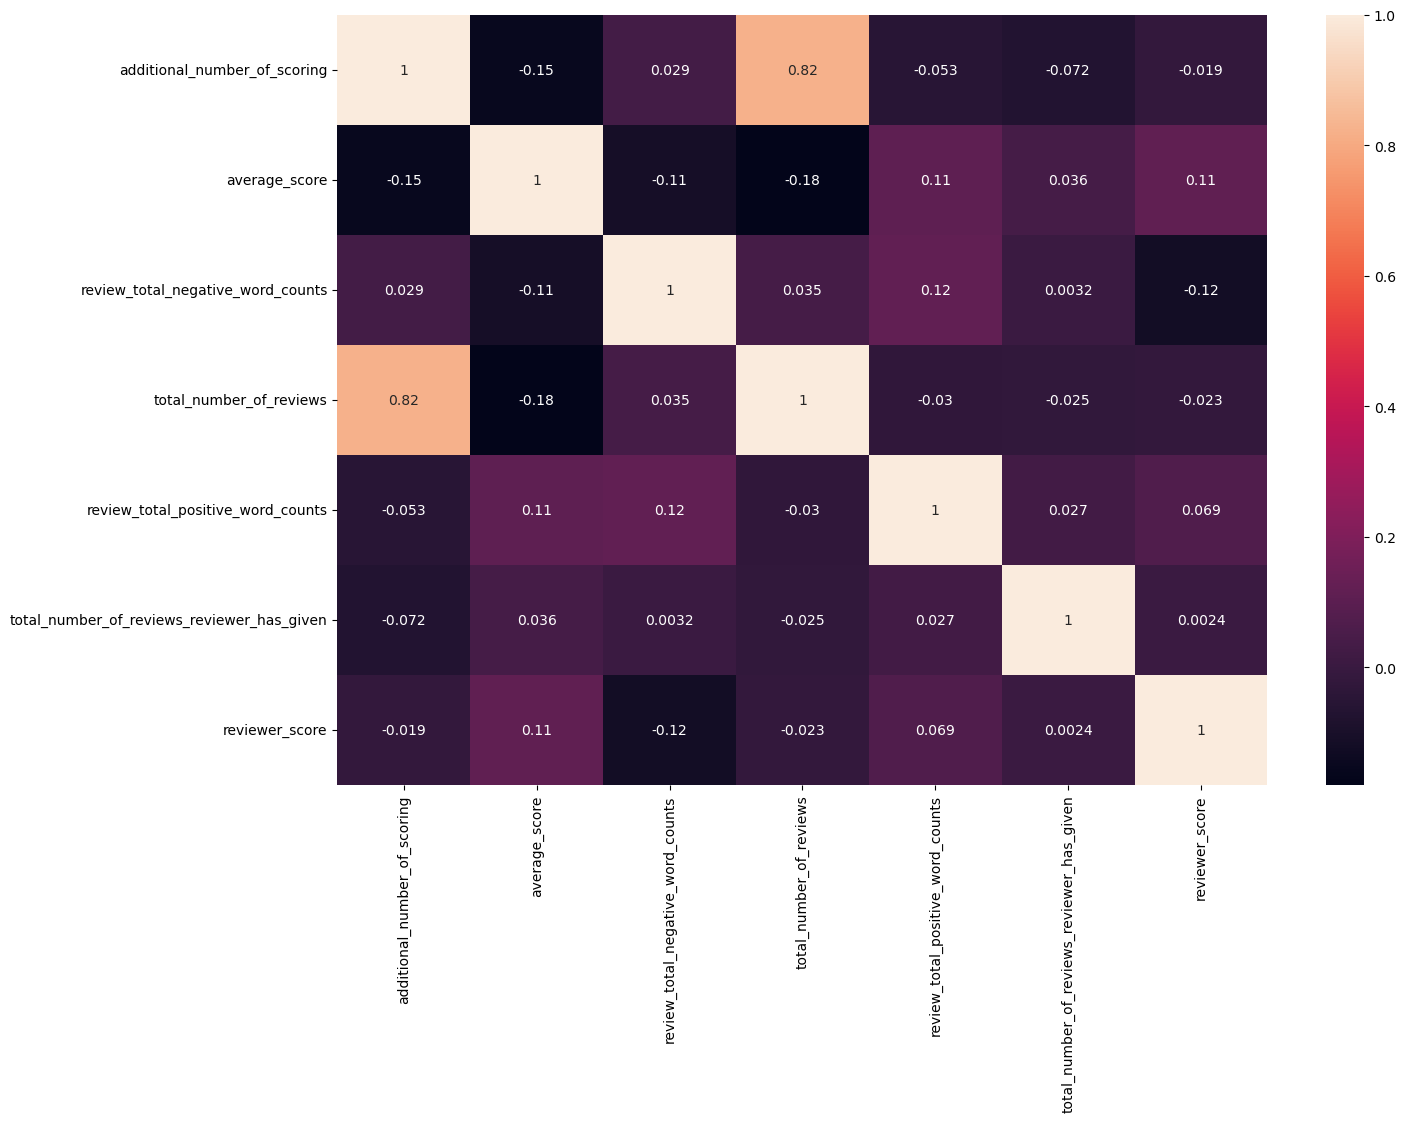

In [19]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(hotels.drop(['sample'], axis=1).corr(), annot=True)

Text(0.5, 1.0, 'Распределение оценок')

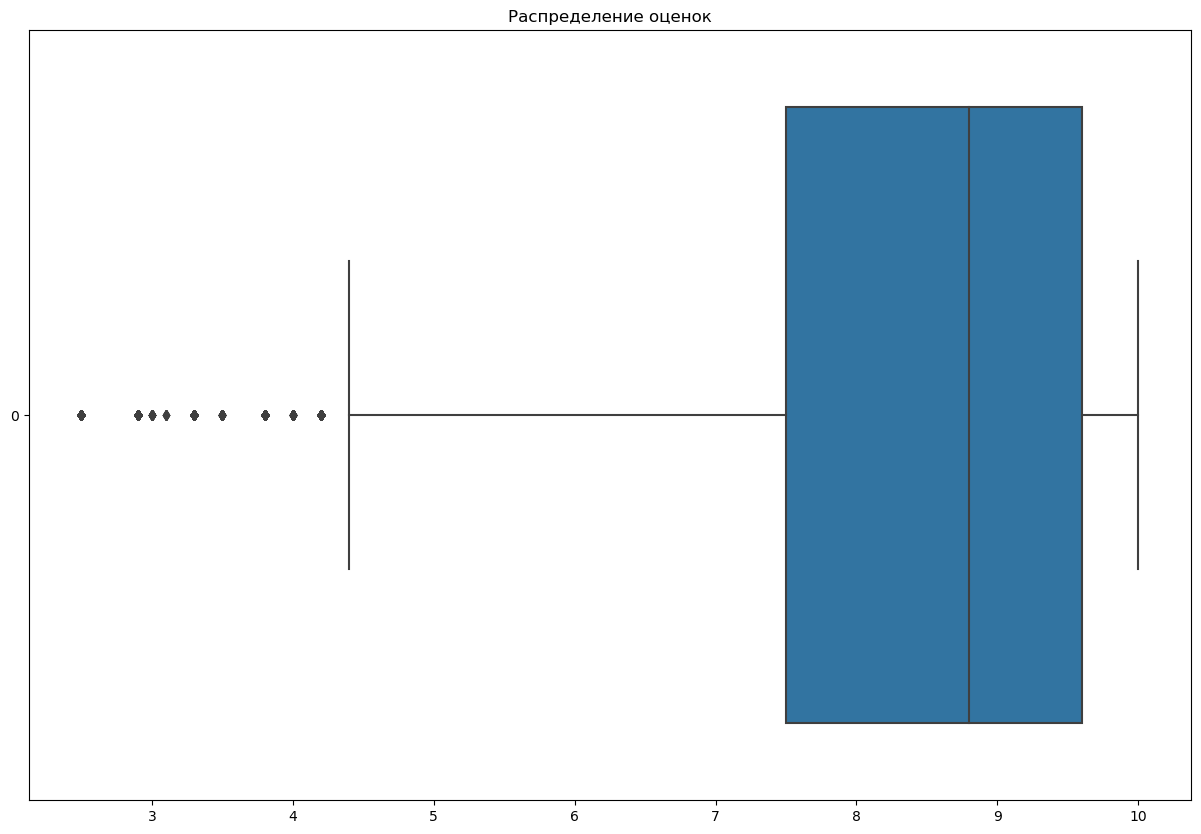

In [20]:
hotels_reviewer_score_box = sns.boxplot(hotels_train['reviewer_score'], orient='h')
hotels_reviewer_score_box.set_title('Распределение оценок')

Можно заметить, что оценка отеля может лежать в диапазоне от 0 до 10. Коробчатая диаграмма показывает, что 50% оценок лежат между значениями примерно в 7.5 и 9.5.

# Проектирование признаков

Посмотрим на типы данных в нашем наборе

In [21]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

## Дата публикации отзыва (review_date)

In [22]:
# Изменение формата представления даты отзыва
hotels['review_date'] = pd.to_datetime(hotels['review_date'])

# Новый признак - год отзыва
hotels['review_year'] = hotels['review_date'].dt.year

# Новые признаки - сезон отзыва
def get_seasons(month):
    """Функция преобразует дату во времена года

    Args:
        month (int): номер месяца
        
    Returns:
        str: название времени года
    
    """
    if month in list(range(3,6)):
        return 'spring'
    elif month in list(range(6,9)):
        return 'summer'
    elif month in list(range(9,12)):
        return 'autumn'
    else:
        return 'winter'



hotels['review_seasons'] = hotels['review_date'].dt.month.apply(get_seasons)

In [24]:
pivot_seasons = hotels.groupby(['review_year', 'review_seasons'])['reviewer_score'].mean()
pivot_seasons

review_year  review_seasons
2015         autumn            6.212497
             summer            6.264161
             winter            6.342589
2016         autumn            6.242509
             spring            6.360973
             summer            6.309405
             winter            6.354133
2017         spring            6.277652
             summer            6.274948
             winter            6.353192
Name: reviewer_score, dtype: float64

Преобразуем признак 'review_date' в datetime

In [26]:
ohe_col = ['review_year', 'review_seasons']
hotels = pd.get_dummies(hotels, columns=ohe_col)

Далее выделим в отдельные признаки месяц и сезон, в котором был написан отзыв

In [27]:
hotels['review_date_month'] = pd.to_datetime(hotels['review_date']).dt.month

def get_season(x):
    if x in [1,2,12]:
        return 1
    elif x in [3,4,5]:
        return 2
    elif x in [6,7,8]:
        return 3
    elif x in [9,10,11]:
        return 4

hotels['review_date_season'] = hotels['review_date_month'].apply(get_season)
print(hotels)

                                            hotel_address  \
0       Stratton Street Mayfair Westminster Borough Lo...   
1       130 134 Southampton Row Camden London WC1B 5AF...   
2        151 bis Rue de Rennes 6th arr 75006 Paris France   
3       216 Avenue Jean Jaures 19th arr 75019 Paris Fr...   
4               Molenwerf 1 1014 AG Amsterdam Netherlands   
...                                                   ...   
515733  Viale Monza 132 Distretto Viale Monza 20127 Mi...   
515734  Duc De Medinaceli 8 Ciutat Vella 08002 Barcelo...   
515735  Wiedner Hauptstra e 44 04 Wieden 1040 Vienna A...   
515736  Corso Concordia 1 Milan City Center 20129 Mila...   
515737       202 rue de Rivoli 1st arr 75001 Paris France   

        additional_number_of_scoring review_date  average_score  \
0                                581  2016-02-19            8.4   
1                                299  2017-01-12            8.3   
2                                 32  2016-10-18            8.9   

Посмотрим, меняется ли средняя оценка и количество отзывов в зависимости от месяца

Text(0.5, 1.0, 'Зависимость средней оценки от месяца отзыва')

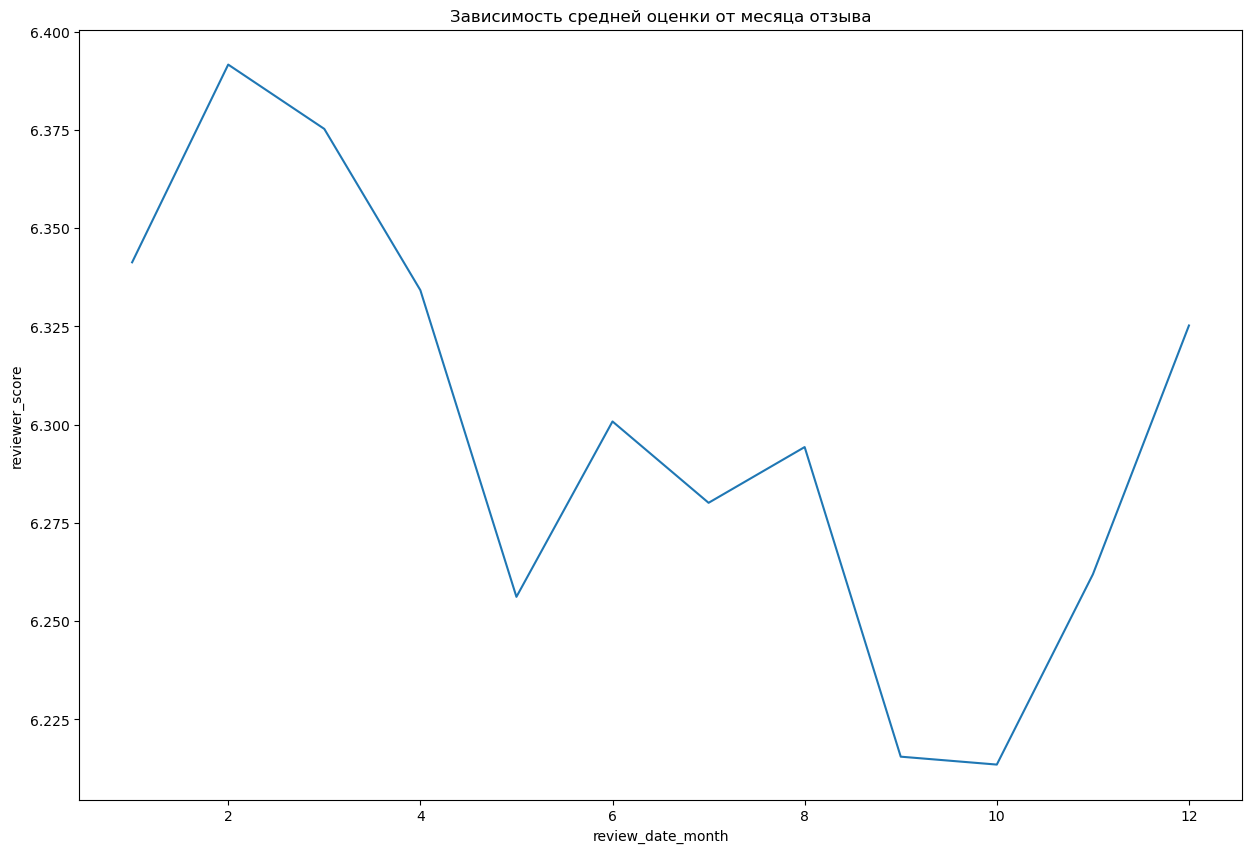

In [28]:
hotels_date_gb = hotels.groupby('review_date_month')['reviewer_score'].agg('mean').reset_index()
hotels_date_gb_line = sns.lineplot(hotels_date_gb, x='review_date_month', y='reviewer_score')
hotels_date_gb_line.set_title('Зависимость средней оценки от месяца отзыва')

Text(0.5, 1.0, 'Количество отзывов в зависимости от месяца')

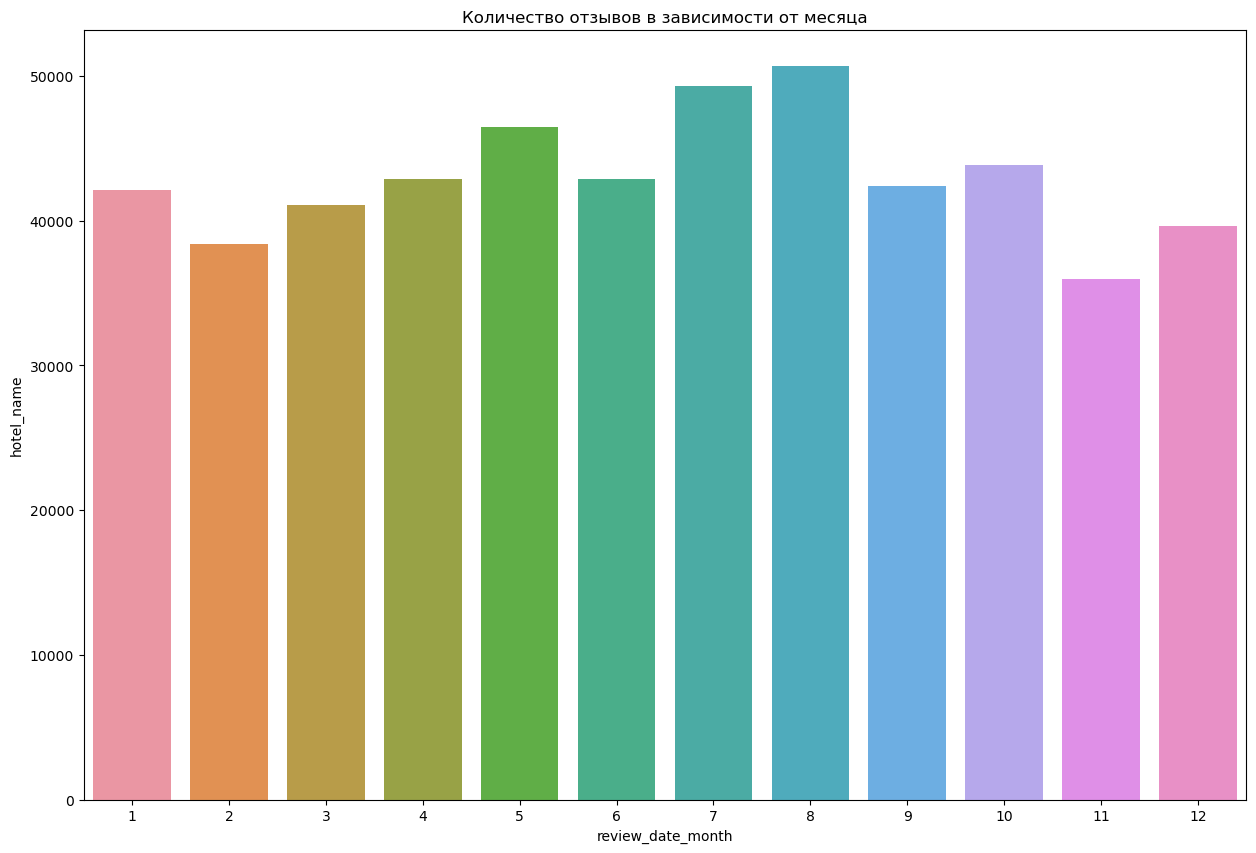

In [29]:
hotels_date_gb = hotels.groupby('review_date_month')['hotel_name'].agg('count').reset_index()
hotels_date_gb_bar = sns.barplot(hotels_date_gb, x='review_date_month', y='hotel_name')
hotels_date_gb_bar.set_title('Количество отзывов в зависимости от месяца')

Посмотрим, меняется ли средняя оценка и количество отзывов в зависимости от сезона

Text(0.5, 1.0, 'Зависимость средней оценки от сезона, в котором был написан отзыв')

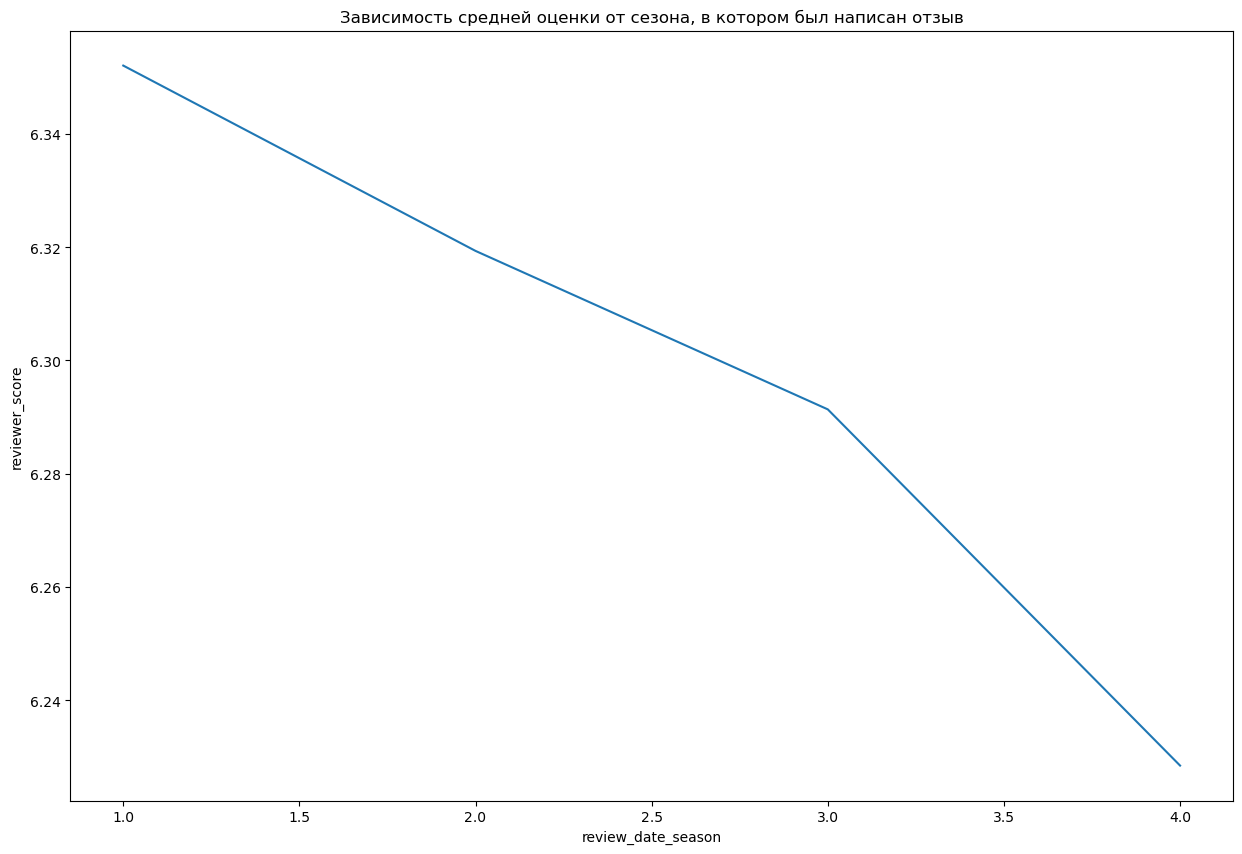

In [30]:
hotels_date_gb = hotels.groupby('review_date_season')['reviewer_score'].agg('mean').reset_index()
hotels_date_gb_line = sns.lineplot(hotels_date_gb, x='review_date_season', y='reviewer_score')
hotels_date_gb_line.set_title('Зависимость средней оценки от сезона, в котором был написан отзыв')

Text(0.5, 1.0, 'Количество отзывов в зависимости от сезона, в котором был написан отзыв')

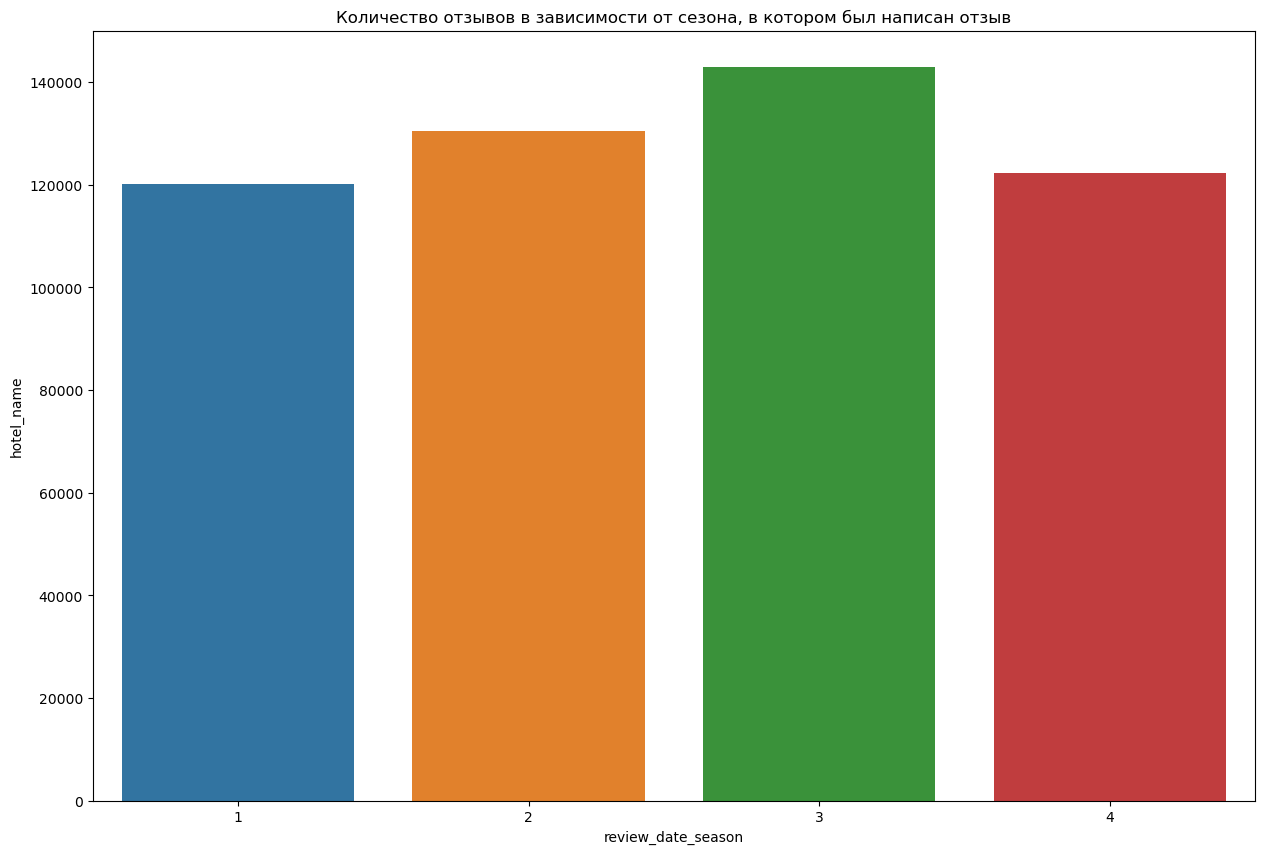

In [31]:
hotels_date_gb = hotels.groupby('review_date_season')['hotel_name'].agg('count').reset_index()
hotels_date_gb_bar = sns.barplot(hotels_date_gb, x='review_date_season', y='hotel_name')
hotels_date_gb_bar.set_title('Количество отзывов в зависимости от сезона, в котором был написан отзыв')

Средняя оценка, как и количество отзывов, незначительно изменяются в зависимости от месяца и сезона. Возможно эти признаки будут полезными для нас

## Тэги (tags)

Добавим столбец с количеством тэгов у отзыва

In [32]:
def get_number_of_tags(tags):
    tags = tags[2:-2]
    res = tags.strip().split(' \', \' ')
    return len(res)

hotels['number_of_tags'] = hotels['tags'].apply(get_number_of_tags)

hotels['number_of_tags'].value_counts()

5    297823
4    211564
3      5505
6       755
2        85
1         6
Name: number_of_tags, dtype: int64

Преобразуем тэги из строки в список

In [33]:
def rev_func(num_tags):
    num_tags = num_tags[2:-2]
    res = num_tags.strip().split(' \', \' ')
    return res

hotels['tags_list'] = hotels['tags'].apply(rev_func)

Создадим новый признак - количество проведенных ночей в отеле

In [34]:
def get_nights(tags):
    for tag in tags:
        if 'Stayed' in tag and ('nights' in tag or 'night' in tag):
            return int(tag.split(' ')[1])
    else:
        return 0

hotels['nights_stayed'] = hotels['tags_list'].apply(get_nights)

Посмотрим, влияет ли количество проведенных ночей в отелях на среднюю оценку и количество отзывов

Text(0.5, 1.0, 'Количество проведенных ночей и средняя оценка')

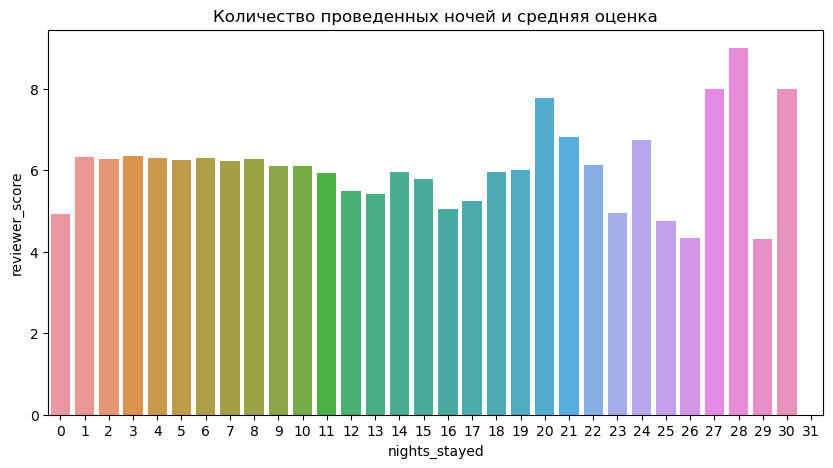

In [35]:
figure = plt.figure(figsize=(10,5))
hotels_nights_stayed_gb = hotels.groupby('nights_stayed')['reviewer_score'].agg('mean').reset_index()
hotels_nights_stayed_gb_bar = sns.barplot(hotels_nights_stayed_gb, x='nights_stayed', y='reviewer_score')
hotels_nights_stayed_gb_bar.set_title('Количество проведенных ночей и средняя оценка')

Из отзывов можно сделать вывод, что большинство проводит в отелях до 7 ночей, так что логично было бы закодировать этот признак

In [36]:
def nights(x):
    if x > 7:
        return 'more_than_7_nights'
    elif x == 0:
        return 'unknown_nights_stayed'
    else:
        return str(x)+'_nights_stayed'
    
hotels['nights_stayed'] = hotels['nights_stayed'].apply(nights)

hotels['nights_stayed'].value_counts()

nights_stayed = pd.get_dummies(hotels['nights_stayed'])
hotels = pd.concat([hotels, nights_stayed], axis=1)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 39 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

## Положительные и негативные составляющие (negative_review и positive_review)

Посмотрим самые частые значения в 'negative_review'

In [37]:
hotels['negative_review'].value_counts()

No Negative                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      127890
 Nothing                                                                                                                                                                                                                        

Создадим новый признак, который помечает, имеются ли негативные стороны у отеля или нет 

In [38]:
def has_negative(negative_review):
    if negative_review.lower().strip() == 'no negative':
        return 0
    elif negative_review.lower().strip() == 'nothing':
        return 0
    else:
        return 1

hotels['has_negative'] = hotels['negative_review'].apply(has_negative)
hotels['has_negative'].value_counts()

1    366663
0    149075
Name: has_negative, dtype: int64

Создадим новый признак, который помечает, имеются ли позитивные стороны у отеля или нет 

In [39]:
hotels['positive_review'].value_counts()

No Positive                                                                                                                                                                    35946
 Location                                                                                                                                                                       9222
 Everything                                                                                                                                                                     2284
 location                                                                                                                                                                       1677
 Nothing                                                                                                                                                                        1243
                                                                                               

In [40]:
def has_positive(positive_review):
    if positive_review.lower().strip() == 'no positive':
        return 0
    elif positive_review.lower().strip() == 'nothing':
        return 0
    else:
        return 1

hotels['has_positive'] = hotels['positive_review'].apply(has_positive)
hotels['has_positive'].value_counts()

1    478061
0     37677
Name: has_positive, dtype: int64

## Страна, в которой находится отель

Создадим сет стран, в которых находится отель

In [41]:
hotels_country_set = set()

for hotel_address in hotels['hotel_address']:
    if ' '.join(hotel_address.split(' ')[-2:]) == 'United Kingdom':
        hotels_country_set.add(' '.join(hotel_address.split(' ')[-2:]))
    else:
        hotels_country_set.add(', '.join(hotel_address.split(' ')[-1:]))

hotels_country_set

{'Austria', 'France', 'Italy', 'Netherlands', 'Spain', 'United Kingdom'}

Сделаем признаки-мигалки стран, в которых находятся отели

In [42]:
def get_hotel_country(x):
    if 'United Kingdom' in x:
        return 'United Kingdom'
    elif 'Spain' in x:
        return 'Spain'
    elif 'Netherlands' in x:
        return 'Netherlands'
    elif 'Italy' in x:
        return 'Italy'
    elif 'France' in x:
        return 'France'
    elif 'Austria' in x:
        return 'Austria'

hotels['hotel_country'] = hotels['hotel_address'].apply(get_hotel_country)
countries = pd.get_dummies(hotels['hotel_country'])

hotels = pd.concat([hotels, countries], axis = 1)
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,unknown_nights_stayed,has_negative,has_positive,hotel_country,Austria,France,Italy,Netherlands,Spain,United Kingdom
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,...,0,1,1,United Kingdom,0,0,0,0,0,1
1,130 134 Southampton Row Camden London WC1B 5AF...,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,...,0,1,1,United Kingdom,0,0,0,0,0,1
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,2016-10-18,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,...,0,1,0,France,0,1,0,0,0,0


## Координаты центра города

Создадим список городов, в которых находятся отели

In [43]:
hotels_cities_set = set()

for hotel_address in hotels['hotel_address']:
    if ' '.join(hotel_address.split(' ')[-2:]) == 'United Kingdom':
        hotels_cities_set.add(' '.join(hotel_address.split(' ')[-5:-4]))
    else:
        hotels_cities_set.add(', '.join(hotel_address.split(' ')[-2:-1]))

hotels_cities_set

{'Amsterdam', 'Barcelona', 'London', 'Milan', 'Paris', 'Vienna'}

Получив все города, в которых есть отели, создадим два признака для координат центра города

In [44]:
def get_center_lat(x):
    if 'Amsterdam' in x:
        return 52.373024
    elif 'Barcelona' in x:
        return 41.387005
    elif 'London' in x:
        return 51.516505
    elif 'Milan' in x:
        return 45.461477
    elif 'Paris' in x:
        return 48.856663
    elif 'Vienna' in x:
        return 48.208943
    
def get_center_lng(x):
    if 'Amsterdam' in x:
        return 4.892845
    elif 'Barcelona' in x:
        return 2.169990
    elif 'London' in x:
        return -0.163053
    elif 'Milan' in x:
        return 9.172365
    elif 'Paris' in x:
        return 2.351556
    elif 'Vienna' in x:
        return 16.373251
    
hotels['center_lat'] = hotels['hotel_address'].apply(get_center_lat)
hotels['center_lng'] = hotels['hotel_address'].apply(get_center_lng)

# Отбор признаков

Избавимся от нечисловых признаков, так как они не подходят для машинного обучения

In [47]:
# убираем вспомогательные и лишние признаки
drop_list = ['days_since_review', 'review_date', 'lat', 'lng']
for i in hotels.select_dtypes(include=['object']).columns:
    if i not in drop_list:
        drop_list.append(i)
hotels.drop(drop_list, axis=1, inplace=True)

In [48]:
def get_correlated(corr_matrix, thres=0.7):
    """Getting correlated pairs from a correlation matrix 
       with correlation coefficients higher than the threshold

    Args:
        corr_matrix (pandas DataFrame): correlation matrix (e.g., from df.corr())
        thres (float, optional): threshold. Defaults to 0.7 (i.e., coeff > 0.7 or coeff < -0.7).

    Returns:
        pandas Series: correlated pairs and correlation coefficients
    """
    
    correlated_pairs = {}
    
    for col in corr_matrix.columns:
        positive_filter = corr_matrix[col] >= thres
        negative_filter = corr_matrix[col] <= -thres
        match_series = corr_matrix[col][positive_filter | negative_filter]
        for match in match_series.index:
            if match != col and match + ' -- ' + col not in correlated_pairs.keys():
                correlated_pairs.update({col + ' -- ' + match: match_series[match]})
   
    return pd.Series(correlated_pairs).sort_values()


print('Коррелированные пары:')
get_correlated(hotels.corr(method='spearman'))

Коррелированные пары:


United Kingdom -- center_lng                              -0.932033
review_seasons_winter -- review_date_season               -0.756508
reviewer_score -- sample                                   0.758772
review_seasons_autumn -- review_date_season                0.761091
review_total_negative_word_counts -- has_negative          0.787513
additional_number_of_scoring -- total_number_of_reviews    0.859014
dtype: float64

In [50]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels.drop(object_columns, axis = 1, inplace=True)

In [51]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 37 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   reviewer_score                              515738 non-null  float64
 7   sample                                      515738 non-null  int64  
 8   review_year_2015                            515738 non-null  uint8  
 9   review_year_2016                            515738 non-null  uint8  
 

Построим корреляционную матрицу

In [53]:
hotels_corr = hotels.corr()
for column in hotels_corr.columns:
    hotels_corr[column] = hotels_corr[column].apply(lambda x: round(x, 2))

fig = px.imshow(hotels_corr, text_auto=True, height=2000, width=2000)
fig.show()

In [54]:
# Теперь выделим тестовую часть
hotels_train = hotels.query('sample == 1').drop(['sample'], axis=1)
hotels_test = hotels.query('sample == 0').drop(['sample'], axis=1)

y = hotels_train.reviewer_score.values            # наш таргет
X = hotels_train.drop(['reviewer_score'], axis=1)

****Создание и обучение модели****

In [ ]:
hotels_train = hotels.query('sample == 1').drop(['sample'], axis=1)
hotels_test = hotels.query('sample == 0').drop(['sample', 'reviewer_score'], axis=1)

y = hotels_train.reviewer_score.values
X = hotels_train.drop(['reviewer_score'], axis=1)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
hotels_test.shape, hotels_train.shape, X.shape, X_train.shape, X_test.shape

((128935, 36), (386803, 36), (386803, 35), (309442, 35), (77361, 35))

In [60]:
# Создаём и обучаем модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1)

In [61]:
# Делаем предсказание на проверочных данных и рассчитываем метрику
y_pred = model.predict(X_test)

# Функция, вычисляюща Mean Absolute Percentage Error (MAPE)
def mape_func(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

print('MAPE:', mape_func(y_test, y_pred))


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s


MAPE: 13.51425226080396


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished


<AxesSubplot:>

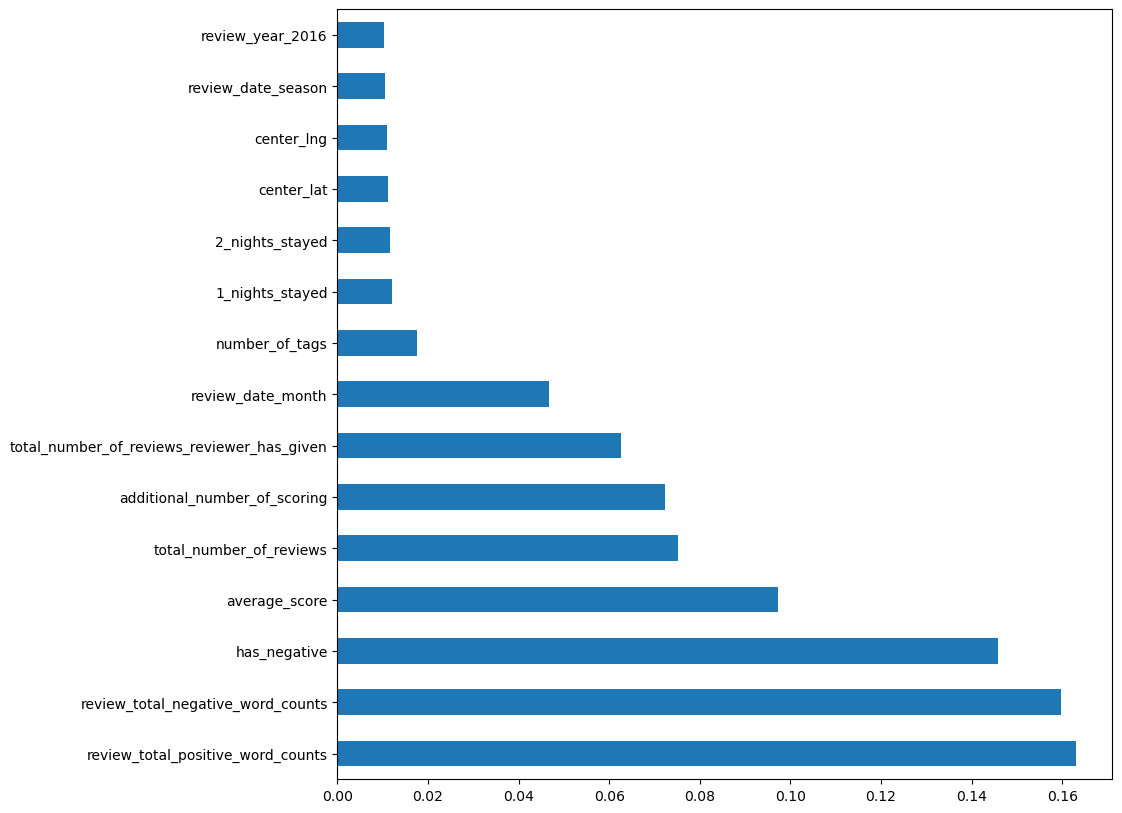

In [62]:
# Выводим самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')